In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight
import seaborn as sns
sns.set(font_scale=1.2)

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
# dfs.extract_df_info()
# df = dfs.df

# Creating train,val,test sets

## Removing outliers

In [4]:
# df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
# df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
# df = df[df.knn_outlier==0]
# df = df[df.nb_contours>0]

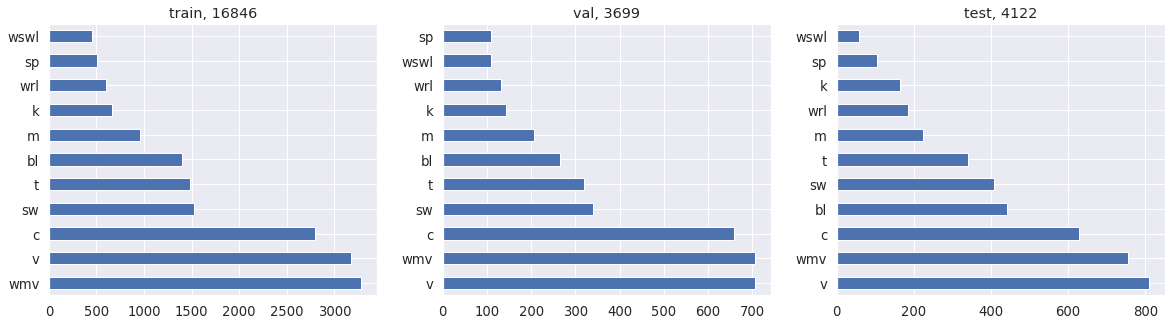

In [5]:
df_train = pd.read_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val = pd.read_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test = pd.read_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

topclasses = df_train['txt_label'].unique().tolist()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [7]:
df_train.label.value_counts()

9     3284
8     3175
7     2798
4     1526
3     1483
0     1402
6      962
5      665
10     597
2      505
1      449
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [8]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

# Defining the model and training parameters

In [9]:
torch.backends.cudnn.benchmark = True

In [10]:
modelname = "vgg19"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weight).cuda(), label_smoothing=.15)

Train on gpu: True


In [11]:
optimizer = optim.Adam(model.parameters(), lr=.001)

model, optimizer = load_checkpoint(f'{SAVE_DIR}/{modelname}_{setting}_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [12]:
labelticks = list({'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}.keys())

In [13]:
train_bacc, train_cm, y_true, y_pred, info = test_model(model,train_dataloader, train_dataset)

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 527/527 [00:36<00:00, 14.49it/s]


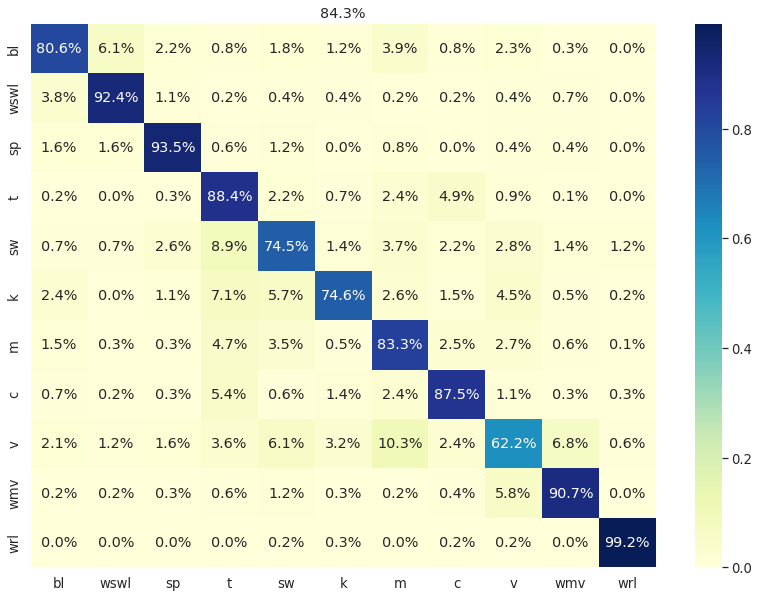

In [14]:
plt.figure(figsize=(14,10))
sns.heatmap(train_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{train_bacc*100:.1f}%");

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:08<00:00, 13.13it/s]


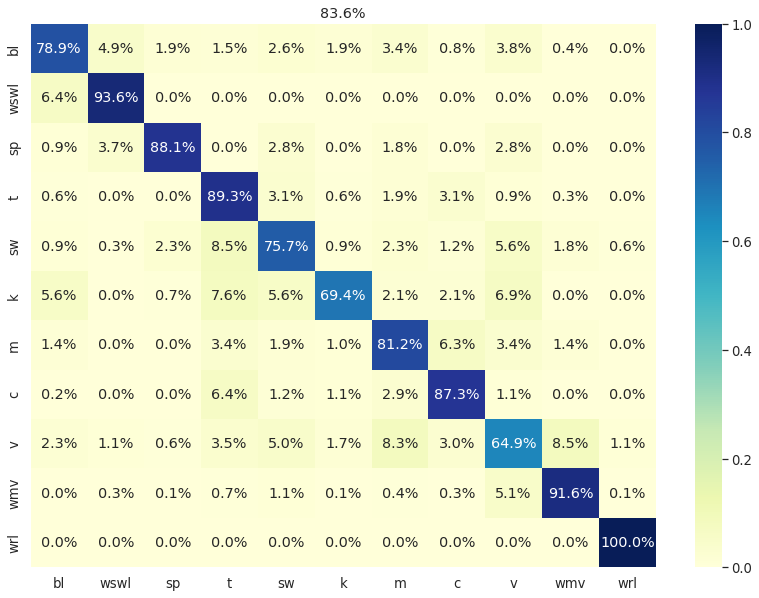

In [15]:
val_bacc, val_cm, _, _, _ = test_model(model,valid_dataloader, valid_dataset)
plt.figure(figsize=(14,10))
sns.heatmap(val_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{val_bacc*100:.1f}%");

Testing..	: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:56<00:00,  2.27it/s]


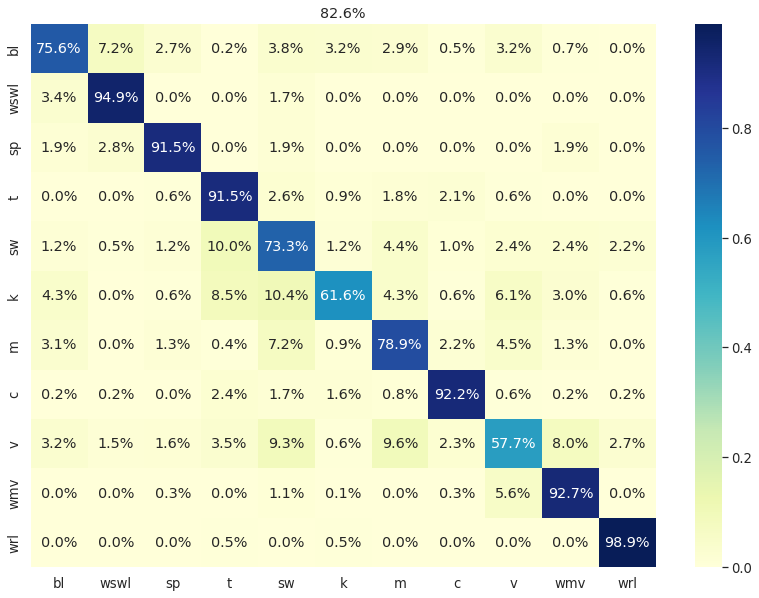

In [16]:
test_bacc, test_cm, y_true, y_pred, info = test_model(model,test_dataloader, test_dataset)
plt.figure(figsize=(14,10))
sns.heatmap(test_cm, annot=True, fmt='.1%', cmap='YlGnBu', xticklabels=labelticks, yticklabels=labelticks); plt.title(f"{test_bacc*100:.1f}%");
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/cm_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

In [17]:
df_train.label.unique()

array([ 7,  9,  3,  0,  6,  8, 10,  4,  2,  1,  5])

In [18]:
df_res = pd.DataFrame(info)
df_res['pred'] = y_pred
df_res['true'] = y_true
df_res['correct'] = df_res.pred==df_res.true

In [19]:
df_pre = pd.read_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')

In [20]:
cols_to_merge = ['imgname','platename','filename','plate_idx','location','date','xtra','year']
df_merged = pd.merge(df_res, df_pre, left_on=cols_to_merge, right_on=cols_to_merge)
mapping = {'bl':'0','wswl':'1','sp':'2','t':'3','sw':'4','k':'5','m':'6','c':'7','v':'8','wmv':'9','wrl':'10'}
mapping = {v: k for k, v in mapping.items()}

df_merged['actual_class'] = df_merged.true.apply(lambda x: mapping[str(x)])
df_merged['pred_class'] = df_merged.pred.apply(lambda x: mapping[str(x)])

<AxesSubplot:>

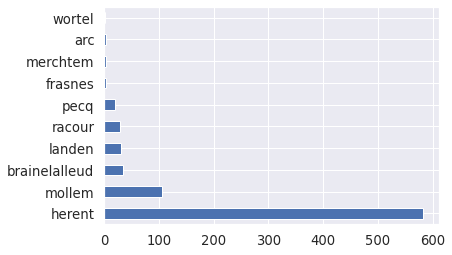

In [21]:
df_merged.query('correct==False').location.value_counts().plot(kind='barh')

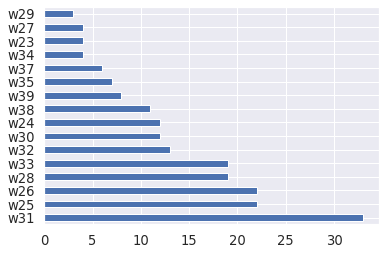

In [22]:
df_merged[df_merged.year=='2021'].query('correct==False').date.value_counts().plot(kind='barh');

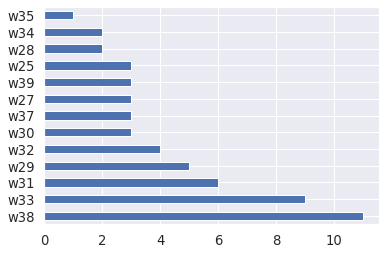

In [23]:
df_merged.query('actual_class==\'wmv\' & pred_class!=\'wmv\'')['date'].value_counts().plot(kind='barh');
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/missclassifications_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

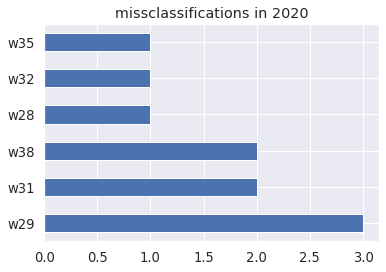

In [24]:
df_merged[df_merged.year=='2020'].query('actual_class==\'wmv\' & pred_class!=\'wmv\'')['date'].value_counts().plot(kind='barh');
plt.title("missclassifications in 2020")
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/missclassifications_2020_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

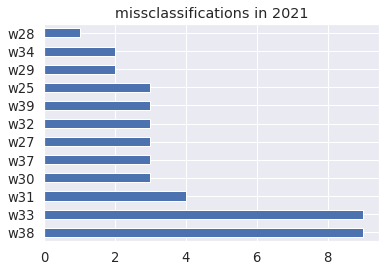

In [25]:
df_merged[df_merged.year=='2021'].query('actual_class==\'wmv\' & pred_class!=\'wmv\'')['date'].value_counts().plot(kind='barh');
plt.title("missclassifications in 2021")
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/missclassifications_2021_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

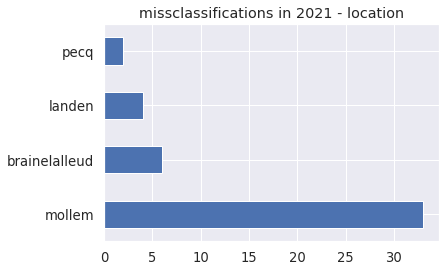

In [26]:
df_merged[df_merged.year=='2021'].query('actual_class==\'wmv\' & pred_class!=\'wmv\'')['location'].value_counts().plot(kind='barh');
plt.title("missclassifications in 2021 - location")
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/missclassifications_2021_location_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

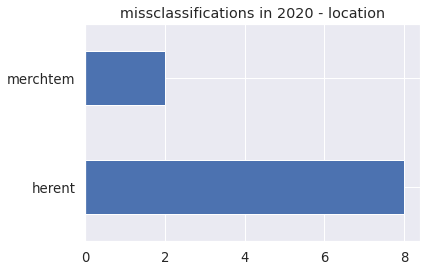

In [27]:
df_merged[df_merged.year=='2020'].query('actual_class==\'wmv\' & pred_class!=\'wmv\'')['location'].value_counts().plot(kind='barh');
plt.title("missclassifications in 2020 - location")
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/missclassifications_2020_location_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

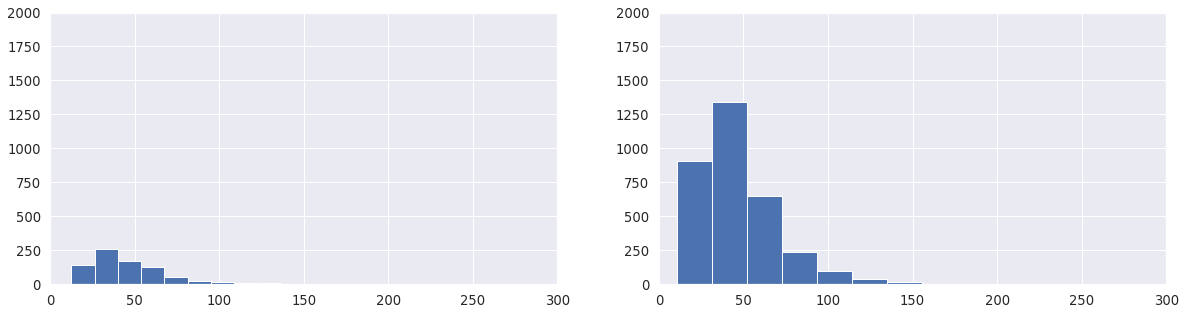

In [28]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')['blur'].hist()
plt.xlim(0,300);plt.ylim(0,2000);

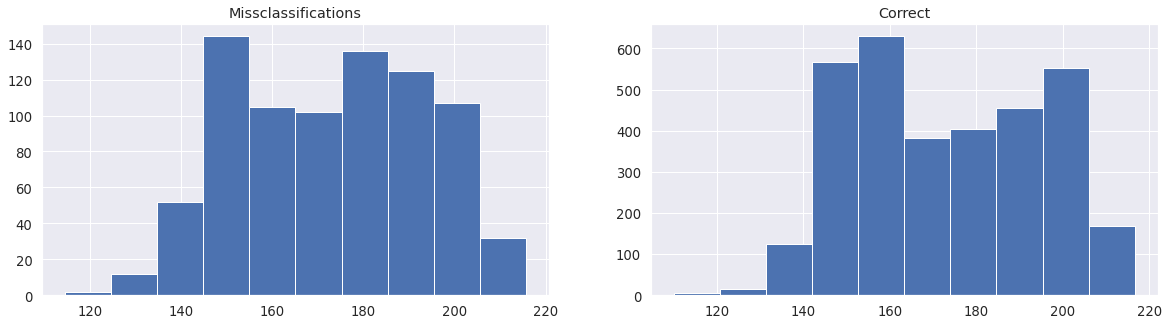

In [29]:
feature = "G"
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_merged.query('correct==False')[feature].hist();plt.title('Missclassifications');
# plt.xlim(0,300);plt.ylim(0,2000)
plt.subplot(1,2,2)
df_merged.query('correct==True')[feature].hist();plt.title('Correct');
# plt.xlim(0,300);plt.ylim(0,2000);

In [30]:
df_merged[df_merged.year=='2020'].query('actual_class==\'wmv\' & pred_class!=\'wmv\' & location==\'herent\'')

,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height,...,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score,actual_class,pred_class
3123,2020_herent_w29_3-90_4056x3040_20200703 92845....,herent_w29_3-90_4056x3040_20200703 92845.jpg,/mnt/EE7455C074558BE9/backups/data_backups/ima...,12373,herent,w29,2020,3-90,tensor(150),tensor(3),...,41.920310,247.636836,60.976258,181.568489,176.503244,182.031022,0,0.190190,wmv,c
3135,2020_UNDISTORTED_herent_w28_4-60_4056x3040_202...,UNDISTORTED_herent_w28_4-60_4056x3040_20200703...,/mnt/EE7455C074558BE9/backups/data_backups/ima...,22975,herent,w28,2020,4-60,tensor(150),tensor(3),...,90.797305,397.253138,89.297131,176.392533,173.981022,180.864978,0,0.137701,wmv,v
3144,2020_herent_w29_4-90_4056x3040_20200703 93205....,herent_w29_4-90_4056x3040_20200703 93205.jpg,/mnt/EE7455C074558BE9/backups/data_backups/ima...,15336,herent,w29,2020,4-90,tensor(150),tensor(3),...,19.942388,157.943374,47.055820,183.815717,179.895320,188.202958,0,0.142658,wmv,v
3146,2020_herent_w29_4-90_4056x3040_20200703 93205....,herent_w29_4-90_4056x3040_20200703 93205.jpg,/mnt/EE7455C074558BE9/backups/data_backups/ima...,15410,herent,w29,2020,4-90,tensor(150),tensor(3),...,59.329086,711.629841,123.833838,175.446446,171.300000,179.611170,0,0.124601,wmv,v
3153,2020_herent_w31_3-90_4056x3040.jpg_wmv_27612,herent_w31_3-90_4056x3040.jpg,/mnt/EE7455C074558BE9/backups/data_backups/ima...,27612,herent,w31,2020,3-90,tensor(150),tensor(3),...,36.513553,188.010064,51.101477,188.897333,184.840222,188.724667,0,0.252278,wmv,c
3157,2020_UNDISTORTED_herent_w32_1-60_4056x3040.png...,UNDISTORTED_herent_w32_1-60_4056x3040.png,/mnt/EE7455C074558BE9/backups/data_backups/ima...,21274,herent,w32,2020,1-60,tensor(150),tensor(3),...,42.108634,227.978739,51.601130,209.707022,198.450267,198.406533,0,0.177547,wmv,k
3165,2020_UNDISTORTED_herent_w31_1-30_4056x3040.png...,UNDISTORTED_herent_w31_1-30_4056x3040.png,/mnt/EE7455C074558BE9/backups/data_backups/ima...,25364,herent,w31,2020,1-30,tensor(150),tensor(3),...,52.478383,256.603975,86.821273,192.610587,187.915556,192.088340,0,0.149452,wmv,v
3225,2020_UNDISTORTED_herent_w35_1-30_4056x3040.png...,UNDISTORTED_herent_w35_1-30_4056x3040.png,/mnt/EE7455C074558BE9/backups/data_backups/ima...,17418,herent,w35,2020,1-30,tensor(150),tensor(3),...,40.896621,231.631607,76.802458,209.114267,207.442711,210.169156,0,0.306985,wmv,v


In [31]:
# dfs.plot_samples(df_merged.query('actual_class!=\'wmv\' & pred_class==\'wmv\''))

In [32]:
# dfs.plot_samples(df_merged.query('nb_contours<=2 & actual_class==\'sw\'' ))

In [33]:
ac_wmv = []
pr_wmv = []
dates = []
for i, sub in df_merged[df_merged.year=='2021'].groupby('date'):
    ac_wmv.append(sub[sub.actual_class=='wmv'].shape[0])
    pr_wmv.append(sub[sub.pred_class=='wmv'].shape[0])
    dates.append(i)

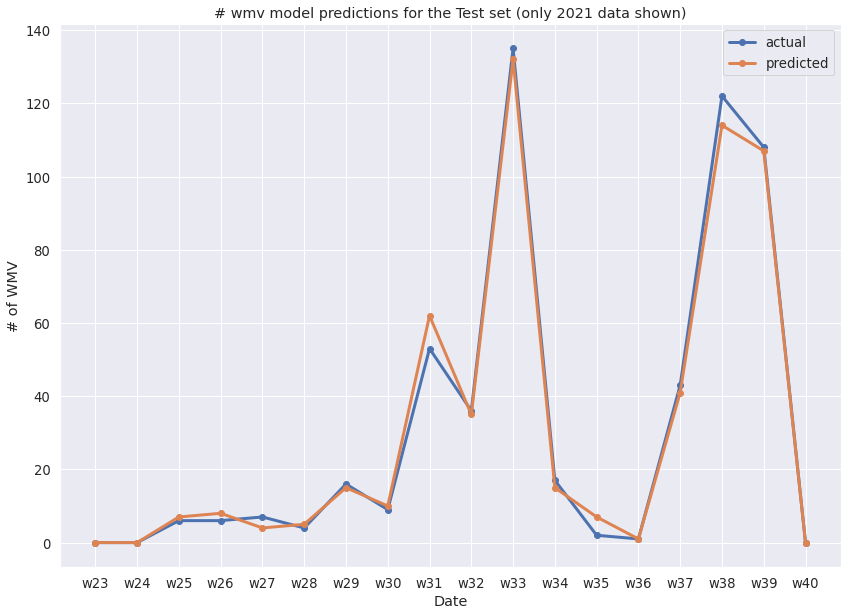

In [34]:
ax = pd.DataFrame({"actual": ac_wmv, "predicted":pr_wmv}).plot(figsize=(14,10), xticks=np.arange(0,len(dates)), linewidth=3,style='o-')
ax.set_xticklabels(dates);
ax.set_ylabel("# of WMV");
ax.set_xlabel("Date")
ax.set_title("# wmv model predictions for the Test set (only 2021 data shown)")
plt.savefig(f"/home/kalfasyan/Dropbox/kuleuven/stickyplate_project/predplot_2020_{modelname}_{setting}_{test_bacc*100:.1f}%.png", format='png', bbox_inches='tight')

In [35]:
dates

['w23',
 'w24',
 'w25',
 'w26',
 'w27',
 'w28',
 'w29',
 'w30',
 'w31',
 'w32',
 'w33',
 'w34',
 'w35',
 'w36',
 'w37',
 'w38',
 'w39',
 'w40']